In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2023-10-05 11:23:15--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  47.1MB/s    in 4.4s    

2023-10-05 11:23:20 (43.6 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip
!ls

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         
ml-20m	ml-20m.zip  sample_data


In [4]:
df=pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
#UserId should be from 0 to n-1 for n users and MovieId should be from 0 to m-1 for m users and there should be no skipping of integers in b/w.This is because the numbers would be used to index an embedding matrix which maps each user and movie to an embedding vector so that we can train the ANN Model.
df.userId=pd.Categorical(df.userId)
df['new_user_id']=df.userId.cat.codes

In [6]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [7]:
#Now convert them into numpy arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [8]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [9]:
#Make the neural network
u=Input(shape=(1,))
m=Input(shape=(1,))
u_emb=Embedding(N,K)(u) ## Output is(num_samples,1,K)
m_emb=Embedding(M,K)(m)
u_emb=Flatten()(u_emb)
m_emb=Flatten()(m_emb) ## Output is(num_samples,K)

##Now we concatenate user-movie embeddings into a feature vector
x=Concatenate()([u_emb,m_emb]) ## Size is now (num_samples,2K)

x=Dense(1024,activation='relu')(x)
x=Dense(1)(x)


In [10]:
model=Model(inputs=[u,m],outputs=x)
model.compile(loss='mse',optimizer=SGD(lr=0.08,momentum=0.9))

In [11]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings as we normally do in neural networks
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [12]:
r = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 [==============================] - 88s 5ms/step - loss: 0.8450 - val_loss: 0.7667
Epoch 2/25
15626/15626 [==============================] - 69s 4ms/step - loss: 0.7470 - val_loss: 0.7424
Epoch 3/25
15626/15626 [==============================] - 72s 5ms/step - loss: 0.7278 - val_loss: 0.7278
Epoch 4/25
15626/15626 [==============================] - 72s 5ms/step - loss: 0.7110 - val_loss: 0.7137
Epoch 5/25
15626/15626 [==============================] - 71s 5ms/step - loss: 0.6970 - val_loss: 0.7037
Epoch 6/25
15626/15626 [==============================] - 73s 5ms/step - loss: 0.6873 - val_loss: 0.6985
Epoch 7/25
15626/15626 [==============================] - 70s 4ms/step - loss: 0.6809 - val_loss: 0.6940
Epoch 8/25
15626/15626 [==============================] - 71s 5ms/step - loss: 0.6765 - val_loss: 0.6921
Epoch 9/25
15626/15626 [==============================] - 70s 5ms/step - loss: 0.6730 - val_loss: 0.6888
Epoch 10/25
15626/15626 [==============================

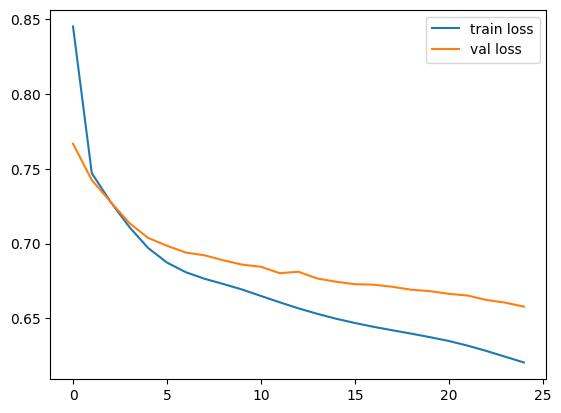

In [13]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [3]:
np.sqrt(0.6279)

0.7924014134263012